## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [36]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import pydicom

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
from itertools import chain
from random import sample 

# Install a pip package in the current Jupyter kernel
import sys
# !{sys.executable} -m pip install opencv-python
# !{sys.executable} -m pip install --upgrade scikit-learn
from cv2 import cv2

import sklearn.preprocessing
import sklearn.model_selection

import skimage

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

import tensorflow.keras.layers
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet import ResNet50 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

Num GPUs Available:  0
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13615081326538142062
]


2021-10-13 18:24:25.160721: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-13 18:24:25.161035: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## Do some early processing of your metadata for easier model training:

In [37]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)

Scans found: 112120 , Total Headers 112120


In [38]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column
# As in Exploring Population Metadata Exercise, split Finding Labels into one per disease to ease processing
def splitFindings(df_src):
    d = df_src.copy()
    all_labels = np.unique(list(chain(*d['Finding Labels'].map(lambda x: x.split('|')).tolist())))
    all_labels = [x for x in all_labels if len(x)>0]
    for c_label in all_labels:
        if len(c_label)>1: # leave out empty labels
            d[c_label] = d['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
    return d, all_labels

all_xray_df, disease_labels = splitFindings(all_xray_df)

In [39]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification
all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia'].map(lambda flag: 'pneumonia' if flag == 1 else 'no finding')

In [40]:
all_xray_df.sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
63255,00015628_002.png,Infiltration,2,15628,52,M,PA,2992,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,no finding
71275,00017575_001.png,Effusion|Pleural_Thickening,1,17575,67,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,no finding
54615,00013670_122.png,Consolidation|Emphysema,122,13670,56,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no finding


## Create your training and testing data:

In [41]:
def create_splits(df):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    train_df, valid_df = sklearn.model_selection.train_test_split(df, 
                                   test_size = 0.2, 
                                   stratify = df['Pneumonia'])
    
    p_inds = train_df[train_df.Pneumonia==1].index.tolist()
    np_inds = train_df[train_df.Pneumonia==0].index.tolist()

    np_sample = sample(np_inds,len(p_inds))
    train_df = train_df.loc[p_inds + np_sample]
    
    # having a 75-25 ratio of pneumonia and no pneumonia in the validation set
    p_inds = valid_df[valid_df.Pneumonia==1].index.tolist()
    np_inds = valid_df[valid_df.Pneumonia==0].index.tolist()

    # The following code pulls a random sample of non-pneumonia data that's 4 times as big as the pneumonia sample.
    np_sample = sample(np_inds,3*len(p_inds))
    valid_df = valid_df.loc[p_inds + np_sample]
    
    return train_df, valid_df

In [42]:
train_df, valid_df = create_splits(all_xray_df)

In [43]:
train_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
41757,00010773_017.png,Pneumonia,17,10773,54,F,AP,2500,2048,0.168000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,pneumonia
40513,00010531_074.png,Consolidation|Pneumonia,74,10531,26,F,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,pneumonia
60362,00014905_004.png,Consolidation|Effusion|Mass|Pneumonia,4,14905,46,M,PA,2992,2991,0.143000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,pneumonia
50367,00012750_002.png,Atelectasis|Pneumonia,2,12750,66,F,PA,2992,2991,0.143000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,pneumonia
18935,00005032_000.png,Pneumonia,0,5032,53,M,PA,2500,2048,0.171000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,pneumonia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107674,00029097_002.png,No Finding,2,29097,61,M,AP,3056,2544,0.139000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no finding
92291,00023065_024.png,Effusion,24,23065,50,F,PA,2021,2021,0.194311,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no finding
52708,00013286_000.png,Fibrosis,0,13286,61,M,PA,2500,2048,0.168000,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no finding
99786,00026428_001.png,No Finding,1,26428,38,F,PA,2544,3056,0.139000,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no finding


In [44]:
valid_df

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
88807,00022021_002.png,Infiltration|Pneumonia,2,22021,57,M,PA,2992,2991,0.143,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,pneumonia
11856,00003092_000.png,Pneumonia,0,3092,53,M,PA,2758,2991,0.143,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,pneumonia
78057,00019169_004.png,Edema|Infiltration|Pneumonia,4,19169,56,F,AP,3056,2544,0.139,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,pneumonia
52514,00013249_038.png,Cardiomegaly|Edema|Effusion|Infiltration|Pneum...,38,13249,15,M,AP,2048,2500,0.168,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,pneumonia
80353,00019750_009.png,Edema|Infiltration|Pneumonia,9,19750,61,M,AP,3056,2544,0.139,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,pneumonia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5021,00001352_000.png,No Finding,0,1352,47,F,PA,2698,2529,0.143,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,no finding
86094,00021222_020.png,Consolidation|Effusion|Infiltration,20,21222,57,M,AP,3056,2544,0.139,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,no finding
45034,00011568_004.png,Effusion,4,11568,45,M,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,no finding
91094,00022708_003.png,Infiltration,3,22708,26,M,AP,3056,2544,0.139,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,no finding


# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [45]:
## Handy constants
INPUT_SHAPE = (224, 224, 3)
PRETRAINED_SHAPE = (224, 224, 3)
IMG_SIZE = (224, 224)
TRAINING_BATCH = 32
VALIDATION_BATCH = 16

## image normalization
def normalize_image(image):
    return (image - np.mean(image)) / np.std(image)

## min-max scaling
def min_max_scaling(image, range=(-1, 1)):
    scaler = sklearn.preprocessing.MinMaxScaler(feature_range=range)
    scaler.fit(image)
    return scaler.transform(image)

def clahe_scaling(image):
        clahe = cv2.createCLAHE()
        return clahe.apply(image)

class MyImageDataGenerator(ImageDataGenerator):
    def __init__(self, **kwargs):
        ''' Custom image data generator.
        Behaves like ImageDataGenerator, but allows color augmentation.
        '''
        super().__init__(
            preprocessing_function=self.preprocess,
            **kwargs)

    def preprocess(self, src):
        '''Takes an input image and returns a modified version of it'''
        dst = cv2.cvtColor(src, cv2.COLOR_RGB2GRAY ) / 255
        dst = skimage.img_as_ubyte(dst)
        dst = clahe_scaling(dst)
        dst = skimage.img_as_float(dst)
#         dst = min_max_scaling(dst, range=(0, 1))
#         dst = normalize_image(dst)
        dst = cv2.cvtColor(dst.astype('float32'), cv2.COLOR_GRAY2RGB ) * 255
        return dst.reshape(src.shape)

# def my_image_augmentation(path):
    
#     ## recommendation here to implement a package like Keras' ImageDataGenerator
#     ## with some of the built-in augmentations 
    
#     ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
#     ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
#     ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
#     ## built into something like a Keras package

#     def generator():
#         for i in range(n_samples):
#             # Synthesize an image and a class label.
#             x = np.random.random_sample(x_shape).astype(np.float32)
#             y = np.random.randint(0, classes, size=y_shape, dtype=np.int32)
#             yield x, y
#     return generator
    
#     return my_idg


def make_train_gen(train_df):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    train_idg = MyImageDataGenerator(horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              zoom_range=0.1)
    
    train_gen = train_idg.flow_from_dataframe(dataframe=train_df, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'pneumonia_class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = TRAINING_BATCH)

    return train_gen


def make_val_gen(valid_df):
    
# Note that the validation data should not be augmented! We only want to do some basic intensity rescaling here
    val_idg = MyImageDataGenerator()

    val_gen = val_idg.flow_from_dataframe(dataframe=valid_df, 
                                             directory=None, 
                                             x_col = 'path',
                                             y_col = 'pneumonia_class',
                                             class_mode = 'binary',
                                             target_size = IMG_SIZE, 
                                             batch_size = VALIDATION_BATCH)
    return val_gen

In [46]:
train_gen = make_train_gen(train_df)
val_gen = make_val_gen(valid_df)

Found 2290 validated image filenames belonging to 2 classes.
Found 1144 validated image filenames belonging to 2 classes.


In [47]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

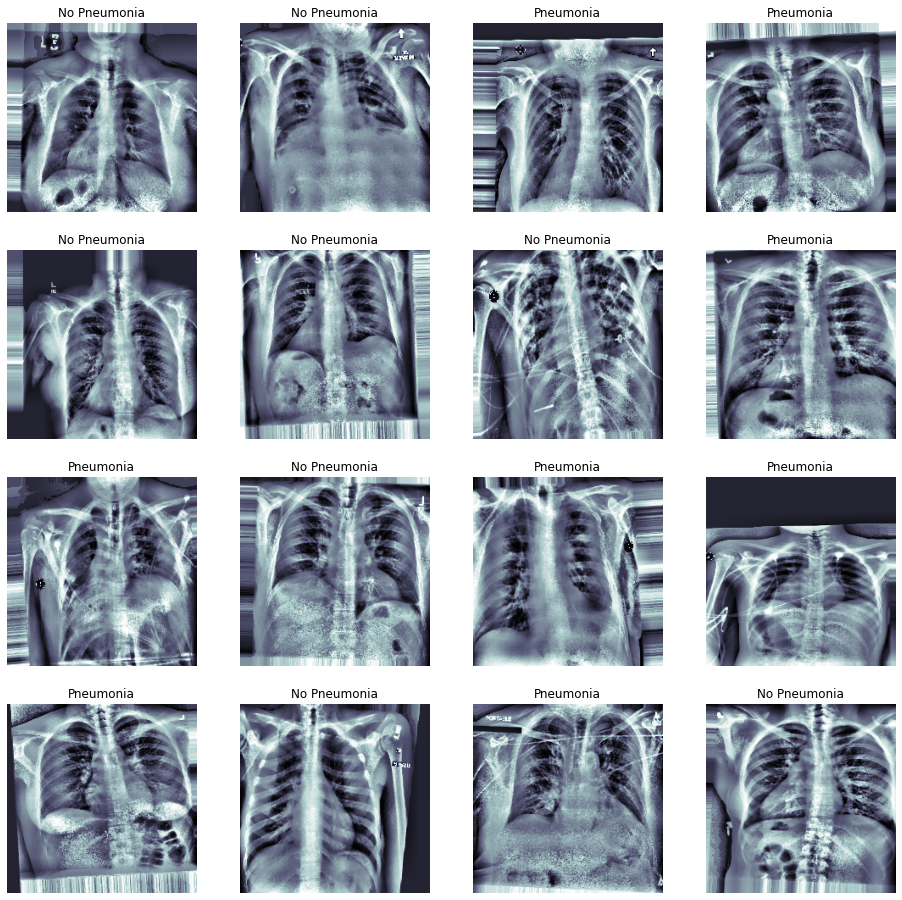

In [48]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')
plt.show()

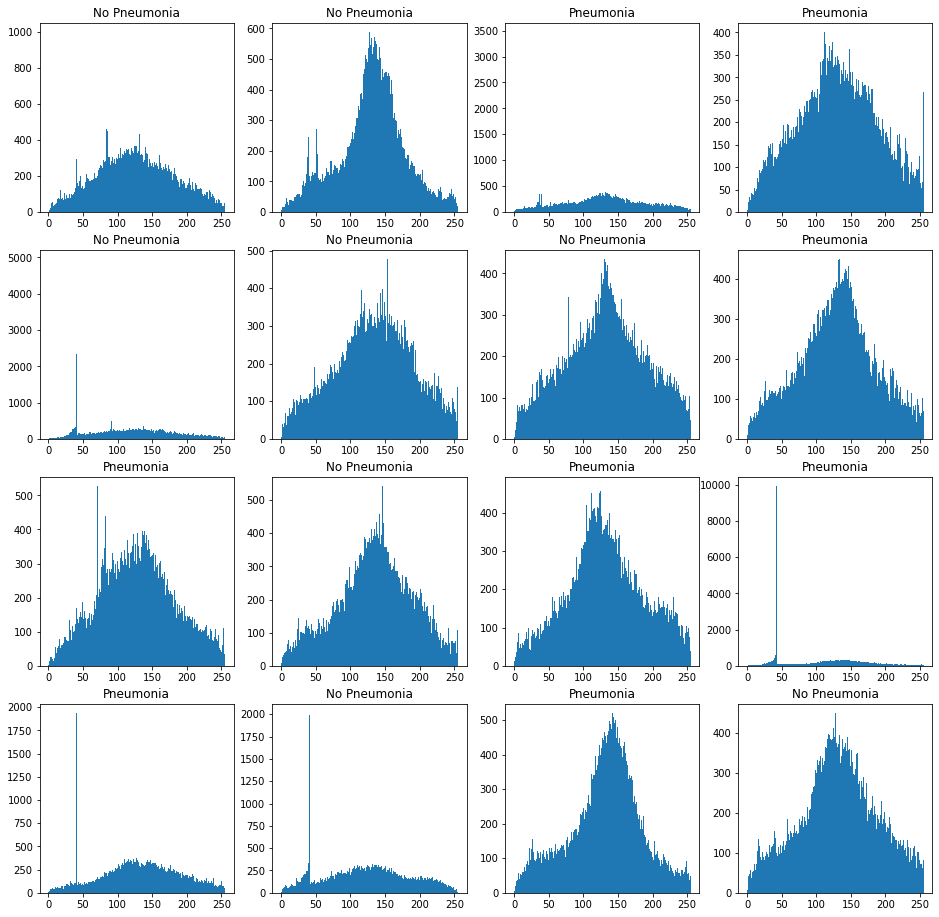

In [49]:
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.hist(c_x[:,:,0].ravel(), bins=256)
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
plt.show()

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [50]:
def loadResNet():
    model = ResNet50(include_top=True, weights='imagenet')
    return model

def loadVGG():
    model = VGG16(include_top=True, weights='imagenet')
    return model

def load_pretrained_model():
    model = loadResNet()
    return model


In [51]:
def build_my_model(learning_rate=1e-5, regularization=1e-5):
    
    my_model = Sequential()
    
#     my_model.add(keras.layers.Input(INPUT_SHAPE))
#     my_model.add(keras.layers.Lambda(lambda x: 
#                                         tf.broadcast_to(x, PRETRAINED_SHAPE), 
#                                     output_shape=PRETRAINED_SHAPE,    
#                                     input_shape=INPUT_SHAPE))

#     img_input = keras.layers.Input(shape=INPUT_SHAPE)
#     img_conc = keras.layers.Concatenate()([img_input, img_input, img_input])  

    my_model.add(tensorflow.keras.layers.Lambda(tf.keras.applications.resnet50.preprocess_input, name='preprocessing', input_shape=INPUT_SHAPE))
    
    pre_trained = load_pretrained_model()
    transfer_layer = pre_trained.get_layer('avg_pool')

    model = Model(inputs=pre_trained.input,
                   outputs=transfer_layer.output)#
        
    my_model.add(model)
    
    for layer in my_model.layers:
        layer.trainable = False
    
#     my_model.add(Flatten())

#     my_model.add(Dropout(0.1))

    my_model.add(Dense(1024, activation='relu', kernel_regularizer=l2(regularization), bias_regularizer=l2(regularization)))

#     my_model.add(Dropout(0.1))

    my_model.add(Dense(512, activation='relu', kernel_regularizer=l2(regularization), bias_regularizer=l2(regularization)))

#     my_model.add(Dropout(0.1))

    my_model.add(Dense(256, activation='relu', kernel_regularizer=l2(regularization), bias_regularizer=l2(regularization)))

#     my_model.add(Dropout(0.1))

    my_model.add(Dense(1, activation='sigmoid'))

    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)

    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 

    # also make sure you set your optimizer, loss function, and metrics to monitor

    ## Set our optimizer, loss function, and learning rate
    optimizer = Adam(learning_rate=learning_rate)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']    

    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    return my_model

# print(load_pretrained_model().summary())

my_model = build_my_model()

print(my_model.summary())
for layer in my_model.layers:
        print(f'{layer.name}: {layer.trainable}')

## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
preprocessing (Lambda)       (None, 224, 224, 3)       0         
_________________________________________________________________
model_1 (Functional)         (None, 2048)              23587712  
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dense_5 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_6 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 26,342,273
Trainable params: 2,754,561
Non-trainable params: 23,587,712
__________________________________

In [54]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting


PATIENCE = 15

METRIC_TO_MONITOR_FOR_PERFORMANCE = 'val_loss'
EVALUATION_MODE = 'auto'

weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= METRIC_TO_MONITOR_FOR_PERFORMANCE, 
                             verbose=1, 
                             save_best_only=True, 
                             mode= EVALUATION_MODE, 
                             save_weights_only = False)

early = EarlyStopping(monitor= METRIC_TO_MONITOR_FOR_PERFORMANCE, 
                      mode= EVALUATION_MODE, 
                      patience=PATIENCE)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./', histogram_freq=1)


callbacks_list = [checkpoint, early, tensorboard_callback]

2021-10-13 18:25:24.507574: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-13 18:25:24.507597: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-13 18:25:24.568594: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-13 18:25:24.568680: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


### Start training! 

In [55]:
## train your model
EPOCHS = 300

history = my_model.fit_generator(train_gen, 
                          validation_data = val_gen, 
                          epochs = EPOCHS, 
                          callbacks = callbacks_list)

/home/perrusi/.local/share/virtualenvs/AIHCND_C2_Starter-tOWvzvVq/lib/python3.8/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
/home/perrusi/.local/share/virtualenvs/AIHCND_C2_Starter-tOWvzvVq/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 1/300
 1/72 [..............................] - ETA: 4:27 - loss: 0.7284 - binary_accuracy: 0.4688

2021-10-13 18:25:30.376555: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-13 18:25:30.376701: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/72 [..............................] - ETA: 1:39 - loss: 0.7103 - binary_accuracy: 0.5312

2021-10-13 18:25:31.724089: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-13 18:25:31.724304: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2021-10-13 18:25:31.770928: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 0 callback api events and 0 activity events. 
2021-10-13 18:25:31.773586: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-13 18:25:31.778528: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./train/plugins/profile/2021_10_13_18_25_31

2021-10-13 18:25:31.781171: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to ./train/plugins/profile/2021_10_13_18_25_31/perrusi-PC.trace.json.gz
2021-10-13 18:25:31.788072: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: ./train/plugins/profile/202

72/72 [==============================] - 147s 2s/step - loss: 0.7082 - binary_accuracy: 0.5594 - val_loss: 0.6492 - val_binary_accuracy: 0.6477

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [56]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
# my_model.load_weights(weight_path)
my_model.load_weights('xray_class_my_model.best.hdf5')
predY = my_model.predict(valX, batch_size = 32, verbose = True)

1/1 [==============================] - 1s 1s/step


In [57]:
def plot_auc(true_y, predicted_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    fpr, tpr, thresholds = sklearn.metrics.roc_curve(true_y, predicted_y)
    roc_auc = sklearn.metrics.auc(fpr, tpr)
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    return roc_auc

## what other performance statistics do you want to include here besides AUC? 


def precision_recall(true_y, predicted_y):
    from sklearn.metrics import PrecisionRecallDisplay
    display = PrecisionRecallDisplay.from_predictions(true_y, predicted_y, name="Estimator")
    _ = display.ax_.set_title("2-class Precision-Recall curve")

# def ...
# Todo
    
#Also consider plotting the history of your model training:

def plot_history(history):
    plt.style.use("ggplot")
    N = len(history["loss"])
    plt.figure()
    plt.plot(np.arange(0, N), history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")
    return

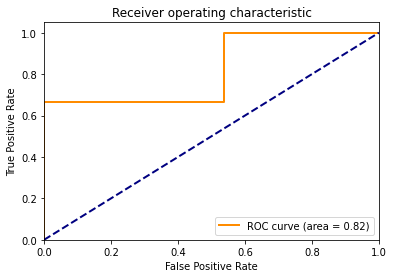

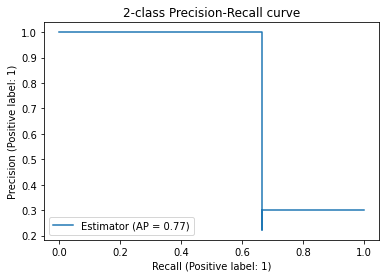

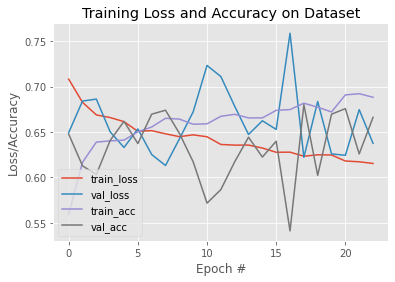

In [58]:
## plot figures
plot_auc(valY, predY)
precision_recall(valY, predY)
plot_history(history.history)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [59]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

fpr, tpr, thresholds = sklearn.metrics.roc_curve(valY, predY)
roc_auc = sklearn.metrics.auc(fpr, tpr)

print(thresholds)
f1_scores = []
for thresh in thresholds:
    f1_scores.append(sklearn.metrics.f1_score(valY, predY > thresh))

threshold = thresholds[np.argmax(f1_scores)]
print(threshold)
print(np.max(f1_scores))
    
#     print(thresholds)
#     for thresh in thresholds:
#         print(sklearn.metrics.f1_score(true_y, predicted_y < thresh))

[1.6780726  0.6780726  0.6544955  0.32237774 0.32125482 0.12767288]
0.6544955
0.5


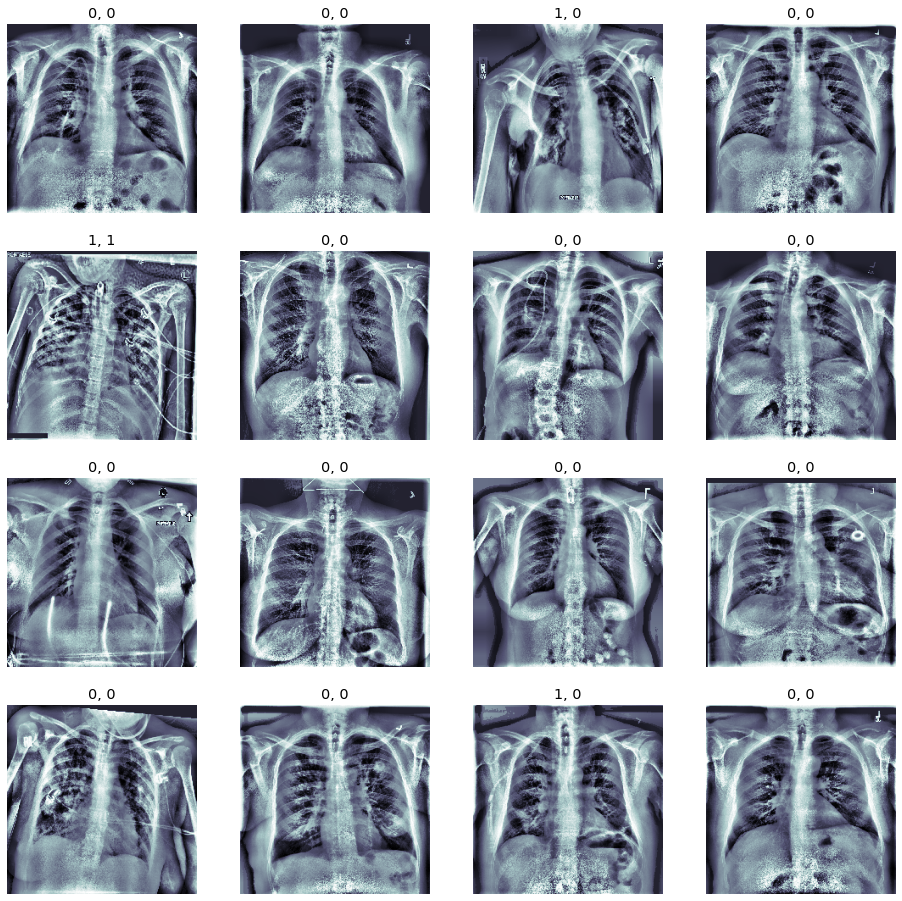

In [60]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if predY[i] > threshold:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if predY[i] > threshold: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [61]:
## Just save model architecture to a .json:

my_model.save("my_model")

# model_json = my_model.to_json()
# with open("my_model.json", "w") as json_file:
#     json_file.write(model_json)

2021-10-13 19:25:32.902002: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: my_model/assets


/home/perrusi/.local/share/virtualenvs/AIHCND_C2_Starter-tOWvzvVq/lib/python3.8/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
